# Exploratory Modelling


This notebook shows how to use **EMA Workbench** for exploratory flood-risk analysis.

- **Model set-up:** a stylised dike-ring system with uncertainties (hydrology, failure probabilities, discount rates) and levers (dike heightening, Room-for-the-River, warning time).
- **Policy experiments:**  
  * **Zero Policy** – all levers at 0 (no measures)  
  * **One Policy** – all levers at 1 (full implementation)
- **Scenario ensemble:** 40 000 randomly generated futures are simulated to evaluate damages and fatalities under both policies.
- **Output handling:** experiments + outcomes are written to compressed `.tar.gz` files for later use.
- **Visualisation:** key results (e.g., Expected Annual Damage vs. Expected Deaths) are displayed with **seaborn/matplotlib**.

In [ ]:
# module imports
from dike_model_function import DikeNetwork
import copy

# problem formulation imports
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

# EMA Workbench imports
from ema_workbench import (
    Model,
    RealParameter, 
    IntegerParameter,
    CategoricalParameter,
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
    Scenario
)
from ema_workbench.util import save_results

# visualization and data analysis imports
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:

# Enable console logging so we can see EMA Workbench progress messages
ema_logging.log_to_stderr(ema_logging.INFO)

# Policy formulation number 1 is chosen
# As this is in line with the intrest of our client the Delta Commision
dike_model, planning_steps = get_model_for_problem_formulation(2)

# Uncertainties are the parameters that are not controlled by the decision-maker
# They represent the uncertainties in the model that can affect the outcomes.
# Each `x` is a Real/Integer/CategoricalParameter with lower–upper bounds
for x in dike_model.uncertainties:
    print(repr(x))

# Make a deep copy so later edits don’t mutate the original model object
uncertainties = copy.deepcopy(dike_model.uncertainties)

# policy levers are the parameters that the decision-maker can control
# They represent the decisions that can be made to influence the outcomes.
# policy levers types (RealParameter/IntegerParameter) with lower-upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# Outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

Explore the behavior of the system in the absence of any release using 40000 scenarios

In [5]:
# Build the SALib ‘problem’ dict in one go
problem = {
    'num_vars': len(uncertainties),
    'names'   : [u.name for u in uncertainties],
    'bounds'  : [
        # For numeric uncertainties keep their true bounds,
        # for categorical ones use an index range 0 … (k-1)
        [u.lower_bound, u.upper_bound] if isinstance(u, (RealParameter, IntegerParameter))
        else [0, len(u.categories) - 1]
        for u in uncertainties
    ]
}

In [6]:
num_scenarios = 40000

In [7]:
# create a new dictionary with all levers set to zero
lever_settings = {lever.name: 0 for lever in levers}

# Define the first policy with all levers set to zero
zero_policy = Policy("Zero Policy", **lever_settings)
# Define the second policy with all levers set to one
one_policy = Policy("One Policy", **{lever.name: 1 for lever in levers})

In [8]:
# Run the experiments using n scenarios
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=num_scenarios, policies=[zero_policy])

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|████████████████████████████████████| 40000/40000 [25:00<00:00, 26.66it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [9]:
# Save the results to a file
save_results((experiments, outcomes), './data/exploratory_results_40000_zero_policy.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/lorenzo/Desktop/Cartelle/Mbd project/MBD-repository/data/exploratory_results_40000_zero_policy.tar.gz


In [10]:
# run the experiments using n scenarios
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments1, outcomes1 = evaluator.perform_experiments(scenarios=num_scenarios, policies=[one_policy])

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|████████████████████████████████████| 40000/40000 [23:25<00:00, 28.46it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [11]:
# Save the results to a file
save_results((experiments1, outcomes1), './data/exploratory_results_40000_one_policy.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/lorenzo/Desktop/Cartelle/Mbd project/MBD-repository/data/exploratory_results_40000_one_policy.tar.gz


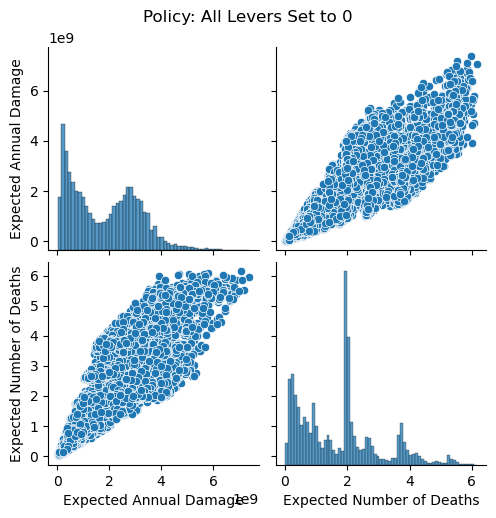

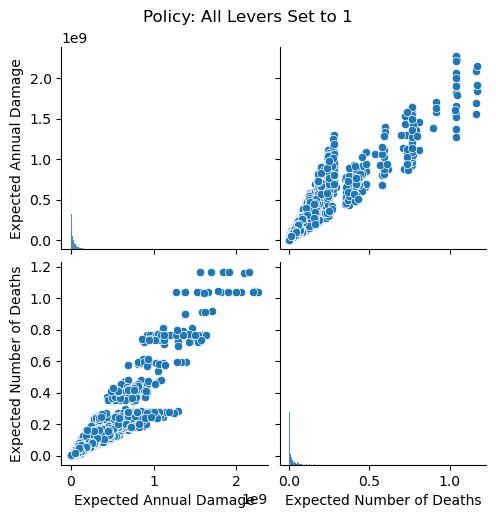

In [20]:
# Conversion of experiments and outcomes to DataFrames
# First the zero policy
experiments_zero_df = pd.DataFrame(experiments) 
outcomes_zero_df = pd.DataFrame(outcomes)

# Second the one policy
experiments_one_df = pd.DataFrame(experiments1)
outcomes_one_df = pd.DataFrame(outcomes1)

# Combination of the experiments and outcomes DataFrames
# This allows us to analyze the results in a single DataFrame
results_zero_df = pd.concat([experiments_zero_df, outcomes_zero_df], axis=1)
results_one_df = pd.concat([experiments_one_df, outcomes_one_df], axis=1)

# Creation of pair plots for policy where levers are set to 0
# only plot the expected annual damage and expected number of deaths because the other outcomes are not 0 for no policy
sns.pairplot(results_zero_df, vars=['Expected Annual Damage','Expected Number of Deaths'])
plt.suptitle('Policy: All Levers Set to 0', y=1.02)
plt.show()

# Generate pair plots for policy where levers are set to 1
sns.pairplot(results_one_df, vars=['Expected Annual Damage', 'Expected Number of Deaths'])
plt.suptitle('Policy: All Levers Set to 1', y=1.02)
plt.show()

## Pair-plot – Zero-Policy (all levers = 0)
**Diagonal histograms**

- Expected Annual Damage (EAD):right-skewed, multimodal; bulk of scenarios lie between €0–5 billion but the tail extends beyond €7 billion, revealing several distinct peaks linked to different dike-ring failures.

- Expected Number of Deaths: similarly skewed with multiple spikes (≈0.5, 2, 4–6 deaths), indicating discrete jumps in exposed population.

**Off-diagonal scatters**

Clear positive correlation: higher damages coincide with higher fatalities, forming an elongated cloud from the origin toward the upper-right.
Three faint “bands” within the cloud mirror the modes in the histograms, each representing a group of scenarios dominated by a particular ring’s failure.

**Implication**
The Zero-Policy option leaves the system highly exposed: both economic losses and fatalities are large on average and highly variable, with pronounced tail risks.

## Pair-plot – One-Policy (all levers = 1)

**Diagonal histograms**

- Expected Annual Damage (EAD): massed near zero; most scenarios fall below €50 million, with a narrow tail stretching to about €2.5 billion.

- Expected Number of Deaths: likewise concentrated near zero; over 75 % of runs yield fewer than 0.02 deaths, and the maximum is just above 1.

**Off-diagonal scatters**

A positive correlation persists, but the cloud is compressed into the lower-left quadrant: even the highest-impact points are far below those in the Zero-Policy plot.
Discrete clusters remain, reflecting residual vulnerability in a few extreme breach scenarios, yet their absolute consequences are an order of magnitude smaller.

**Implication**
With full implementation of dike upgrades, Room-for-the-River measures, and extended warning time, both economic losses and fatalities are dramatically reduced and far less variable, demonstrating the robustness gained through comprehensive prevention.